In [1]:
using LinearAlgebra
using Plots
using Test
using Printf

#####################################
# Méthodes Quasi-Newton implémentée #
#####################################
function BFGS(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-4
    @test norm(Bₖ*sₖ - yₖ) < 10e-4
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    b = yₖ - Bₖ*sₖ
    @test abs(dot(b, sₖ)) > 10e-6*norm(b)*norm(sₖ)
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    @test abs(dot(h, yₖ)) > 10e-6*norm(yₖ)*norm(h)
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

function Broyden(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    HBFGS, BBFGS = BFGS(sₖ, yₖ, Hₖ, Bₖ)
    HDFP, BDFP = DFP(sₖ, yₖ, Hₖ, Bₖ)
    Bₖ = ϕ*BDFP + (1-ϕ)*BBFGS
    Hₖ = inv(Bₖ)
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

Broyden (generic function with 1 method)

In [2]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

In [19]:
function lineSearch(problem, x₀, Δ; affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    pₖ = zeros(length(x₀))
    sₖ = zeros(length(x₀))
    yₖ = zeros(length(x₀))
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    Hₖ, Bₖ = I, I
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    B = problem.Hess(x₀)
    NormP = []
    P = [] 
    NormB = [norm(Bₖ - B)] 
    F = [] 
    eig = []
    α = []
    G = [norm(gₖ)]
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||B-Bₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        if(k != 0)
            Hₖ, Bₖ = update(sₖ, yₖ, Hₖ, Bₖ, ϕ)
            push!(NormB, norm(Bₖ - B))
            push!(eig, real.(eigvals(Bₖ)))
        end
        dₖ = -Hₖ*gₖ # Direction de descente
        ρₖ = 1/dot(yₖ, sₖ)
        bₖ = g(dₖ) - b
        if(abs(dot(gₖ, dₖ)) < 10e-6*norm(gₖ)*norm(dₖ) && negCurvature)
            if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                αₖ = 2*Δ/norm(dₖ)
            else
                dₖ = -gₖ
                bₖ = g(dₖ) - b
                if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                    αₖ = 2*Δ/norm(dₖ)
                else
                    αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
                end
            end
        elseif(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ)  
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            push!(P, pₖ)  
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, P, NormB, F, eig, α, G)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(P, pₖ) 
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k - 1, P, NormB, F, eig, α, G)
end

lineSearch (generic function with 1 method)

In [20]:
function CG(problem, x₀, Δ; maxiter = 1000, ϵ = 10e-8, affichage = true, negCurvature = true)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    pₖ = -rₖ
    βₖ = 0
    k = 0
    xₖ = x₀
    X = []
    normP = []
    F = []
    α = []
    G = [norm(rₖ)]
    if(affichage)
        @printf("%4s %9s %6s %9s %9s %9s %9s \n", "k", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "β")
    end
    while(norm(rₖ) > ϵ && k <= maxiter)
        bₖ = A*pₖ
        if(dot(pₖ, bₖ) <= ϵ && negCurvature)
            if(dot(rₖ, pₖ) < ϵ)
                αₖ = 2*Δ/norm(pₖ) # On force à sortir de la région de confiance
            else
                αₖ = -2*Δ/norm(pₖ)
            end
        else
            αₖ = -dot(rₖ, pₖ)/dot(pₖ, bₖ)
        end
        push!(α, norm(αₖ))
        xₖ += αₖ*pₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(pₖ, rₖ), αₖ, problem.fonction(xₖ), norm(xₖ - x₀), norm(rₖ), βₖ)
        end
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            k += 1
            push!(normP, norm(xₖ - x₀))
            push!(F, problem.fonction(xₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(xₖ), "||p*|| = ", norm(xₖ - x₀)) 
            end
            return(xₖ - x₀, k, normP, F, α, G)
        end
        rₖ = problem.gradient(xₖ)
        βₖ = dot(rₖ, bₖ)/dot(pₖ, bₖ)
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        push!(F, problem.fonction(xₖ))
        push!(normP, norm(xₖ - x₀))
        push!(G, norm(rₖ))
    end
    return(xₖ - x₀, k, normP, F, α, G)
end

CG (generic function with 1 method)

In [23]:
using LinearOperators

function LMlineSearch(problem, x₀, Δ; r = 5, affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    n = length(x₀)
    pₖ = zeros(n)
    yₖ = zeros(n)
    sₖ = zeros(n)
    S = []
    Y = []
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    B = problem.Hess(x₀)
    Hₖ = InverseLBFGSOperator(n, r, scaling = false)
    NormP = []
    P = [] 
    F = []
    α = []
    G = [norm(gₖ)]
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        dₖ = -Hₖ*gₖ # Direction de descente
        bₖ = g(dₖ) - b
        if(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        ρₖ = 1/dot(sₖ, yₖ)
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        # Mise à jour de la liste des yₖ et sₖ
        push!(Hₖ, sₖ, yₖ)
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ) 
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            push!(P, pₖ)  
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, P, F, α, G)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(P, pₖ)   
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k - 1, P, F, α, G)
end

LMlineSearch (generic function with 1 method)

In [62]:
N = 6
# d = [1, 2, 3, 4, 3, 6] # Exemple normal (cas particulier, 1 déjà présent dans la matrice de départ)
# d = [3, 4, 10, 3, 2, 10]
# d = [3, 10, 7, 2, 5, 9]
# d = [1, 1, 1, 1, 1, 1]
# d = [10e-8, 8e-8, 4e-8, 3e-8, 2e-8, 1e-8] # matrice quasi-singulière et petit conditionnement (décrochage de SR1)
# d = [10e-5, 8, 4e3, 3e5, 2e2, 10e-2] # matrice avec gros conditionnement
# d = [10e-4, 8e3, 40e-5, 3e4, 2e-4, 10e-2] # matrice quasi-singulière avec gros contionemment (1) (décallage de CG)
# d = [10e-4, 8e3, 40, 3000, 2e-8, 10e-2] # matrice quasi-singulière avec gros contionemment (2) (décrochage de BFGS)
# d = [0.015, 3.5, -0.15, -0.25, 0.95, 111.5] # Exemple où la norme de p n'est pas croissante
# d = [0.015, 3.5, 15, 25, 0.0095, -111.5] # Exemple où l'erreur de ||Bₖ - B|| pour BFGS augmente avec SR1
# d = [-0.015, 3.5, -15, 25, -0.0095, 111.5] # Exemple où BFGS meilleur que SR1
# d = [-0.015, 3.5, 15, 25, -0.0095, 111.5] # Exemple où SR1 produit une direction ascendante à la fin (avec negCurvature = false)
# d = [3000, -4000, -3000, -0.250, 0.25, 4000] # Yoyo
N, d = 6, [-1, 0.9, -0.8, 0.15, 3.1, 3] # SR1 : alpha > 0 alors que courbure négative
# N, d = 15, [10, 9, 8, 0.35, 3.5, 3, 2, 1, 13, 20, 4.4, 7, 2.9, 0.1, 1.2]

# Construction d'une matrice symétrique de la forme QᵗDQ
D = Diagonal(d)  
A = rand(N, N)
Q, R = qr(A) #
A = transpose(Q)*D*Q
b = rand(N)

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

ArgumentError: ArgumentError: Package Rationals not found in current path:
- Run `import Pkg; Pkg.add("Rationals")` to install the Rationals package.


In [7]:
N = 100
A = rand(-30:0.1:30, N, N)
A = A'*A
b = rand(-30:0.1:30, N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
# x₀ = -A\b - 10e-4*ones(N)
x₀ = zeros(N)
println(real.(eigvals(A)))
println("A⁻¹b - x₀ = ", -A\b)

[0.693471, 13.633, 34.6998, 70.8686, 127.159, 203.598, 265.825, 316.937, 427.46, 554.006, 672.478, 1012.78, 1320.47, 1545.37, 1711.93, 1933.43, 2242.71, 2350.24, 2401.19, 2694.72, 2946.3, 3417.16, 3671.42, 3881.65, 4076.32, 4559.65, 4951.61, 5609.47, 6104.36, 6506.21, 7415.18, 7694.82, 7926.46, 8471.96, 9109.73, 9860.87, 10419.1, 10938.4, 11353.0, 12112.6, 13061.0, 13373.1, 13609.0, 13933.8, 15516.8, 15953.3, 16808.2, 16904.0, 17716.5, 18077.3, 18814.5, 20669.7, 21306.7, 22494.8, 22786.7, 23728.6, 25663.4, 26744.5, 27848.8, 29330.9, 30218.1, 31399.7, 32358.6, 34134.7, 34898.7, 35978.0, 36668.0, 37343.1, 39389.5, 40243.3, 42800.2, 43715.9, 45514.2, 46814.2, 48200.2, 48739.4, 51553.0, 52367.7, 54077.0, 55905.6, 57486.1, 58863.1, 59995.9, 62242.3, 64337.3, 65877.6, 66705.9, 70855.4, 72497.5, 74533.9, 77215.4, 81020.8, 83430.2, 86954.5, 90511.5, 93056.1, 97332.2, 98150.4, 1.08309e5, 1.13439e5]
A⁻¹b - x₀ = [-1.09275, 1.2342, 0.577654, 0.361629, 0.104835, -0.487031, -0.0920472, 0.732927, -1.

In [60]:
nC = false
Δ = Inf
println("Méthode L-BFGS")
p, NormP, iter, P, F, α, G = LMlineSearch(quadratic, x₀, Δ, r = 70, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₁, NormP₁, iter₁, P₁, F₁, α₁, G₁ = LMlineSearch(quadratic, x₀, Δ, r = 1, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₆, NormP₆, iter₆, P₆, F₆, α₆, G₆ = LMlineSearch(quadratic, x₀, Δ, r = 80, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₃, NormP₃, iter₃, P₃, F₃, α₃, G₃ = LMlineSearch(quadratic, x₀, Δ, r = 60, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₄, NormP₄, iter₄, P₄, F₄, α₄, G₄ = LMlineSearch(quadratic, x₀, Δ, r = 30, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₅, NormP₅, iter₅, P₅, F₅, α₅, G₅ = LMlineSearch(quadratic, x₀, Δ, r = 90, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₇, NormP₇, iter₇, P₇, F₇, α₇, G₇ = LMlineSearch(quadratic, x₀, Δ, r = 95, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode BFGS")
p₂, NormP₂, iter₂, P₂, NormB₂, F₂, eig₂, α₂, G₂ = lineSearch(quadratic, x₀, Δ, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC); 

println("")
println("Méthode du GC")
pᵧ, iterᵧ, Pᵧ, Fᵧ, αᵧ, Gᵧ = CG(quadratic, x₀, Δ, maxiter = 2*N, ϵ = 10e-6, negCurvature = nC)

@printf("%22s %8.1e \n","(L-BFGS r = 70) ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(L-BFGS r = 1)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₁)))
@printf("%22s %8.1e \n","(BFGS)          ||g(x₀ + p)|| = ", norm(g(x₀ + p₂)))
@printf("%22s %8.1e \n","(L-BFGS r = 50) ||g(x₀ + p)|| = ", norm(g(x₀ + p₃)))
@printf("%22s %8.1e \n","(L-BFGS r = 30) ||g(x₀ + p)|| = ", norm(g(x₀ + p₄)))
@printf("%22s %8.1e \n","(L-BFGS r = 90) ||g(x₀ + p)|| = ", norm(g(x₀ + p₅)))
@printf("%22s %8.1e \n","(L-BFGS r = 80) ||g(x₀ + p)|| = ", norm(g(x₀ + p₆)))
@printf("%22s %8.1e \n","(CG)            ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))

Méthode L-BFGS
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  3.4e+00 -2.3e+00  6.7e-01 -7.5e-01  1.0e+00  1.5e+00      Inf 
   1 -1.2e+00 -2.4e+00 -2.1e+00  1.7e+00  3.9e+00  1.5e+00      Inf 
   2  3.7e+00 -1.2e+01  3.3e+00 -1.9e+01  1.2e+01  3.5e+00 -2.5e-02 
   3 -1.0e+03 -2.0e+02 -2.0e-01  4.1e-01  1.5e+00  1.4e+01  1.9e+14 
   4  5.3e+00 -2.3e+00  4.2e-01 -7.5e-02  1.3e+00  1.5e+00 -1.0e+00 
   5 -7.1e-01 -6.7e-01 -9.5e-01  2.4e-01  2.7e+00  8.2e-01  3.3e+15 
   6 -1.3e+01 -3.2e+00 -2.5e-01  6.4e-01  1.9e+00  1.8e+00  1.3e+00 
   7 -1.1e+00 -1.0e+00 -9.6e-01  1.1e+00  3.7e+00  1.0e+00  1.0e+00 
   8 -2.0e+01 -5.1e+00 -2.5e-01  1.8e+00  3.1e+00  2.3e+00  7.8e-01 
   9 -1.8e+00 -1.7e+00 -9.6e-01  2.6e+00  5.1e+00  1.3e+00  6.2e-01 
  10 -3.3e+01 -8.3e+00 -2.5e-01  3.6e+00  4.7e+00  2.9e+00  4.8e-01 
  11 -2.9e+00 -2.7e+00 -9.6e-01  4.9e+00  7.1e+00  1.7e+00  3.8e-01 
  12 -5.3e+01 -1.3e+01 -2.5e-01  6.6e+00  6.8e+00  3.7e+00  3.0e-01 
Méthode L-BFGS


(CG)            ||g(x₀ + p)|| =   1.6e-14 


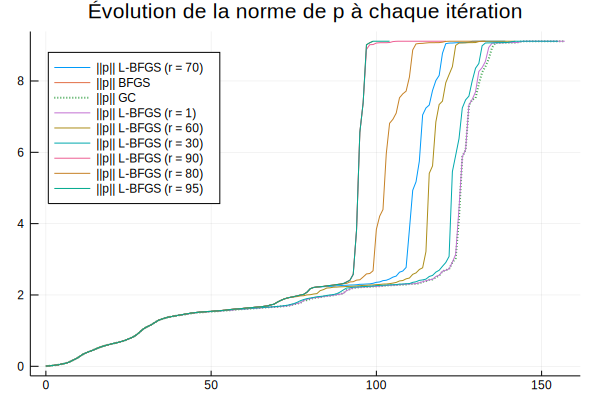

In [55]:
plot(0:iter, NormP, label = "||p|| L-BFGS (r = 70)", title = "Évolution de la norme de p à chaque itération", legend = :topleft)
plot!(0:iter₂, NormP₂, label = "||p|| BFGS")
plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:iter₁, NormP₁, label = "||p|| L-BFGS (r = 1)")
plot!(0:iter₃, NormP₃, label = "||p|| L-BFGS (r = 60)")
plot!(0:iter₄, NormP₄, label = "||p|| L-BFGS (r = 30)")
plot!(0:iter₅, NormP₅, label = "||p|| L-BFGS (r = 90)")
plot!(0:iter₆, NormP₆, label = "||p|| L-BFGS (r = 80)")
plot!(0:iter₇, NormP₇, label = "||p|| L-BFGS (r = 95)")

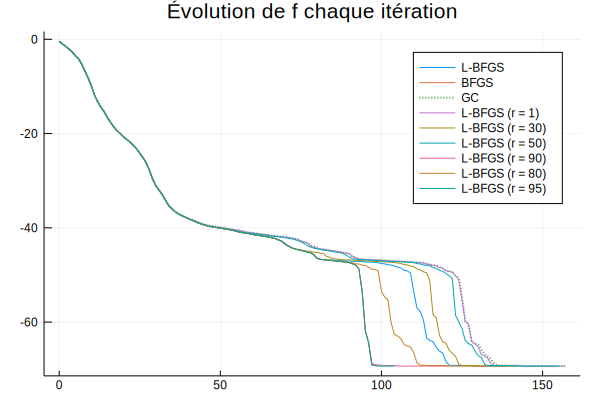

In [56]:
plot(0:iter, F, label = "L-BFGS", title = "Évolution de f chaque itération")
plot!(0:iter₂, F₂, label = "BFGS")
plot!(0:(iterᵧ-1), Fᵧ, label = "GC", lw = 2, line = :dot)
plot!(0:iter₁, F₁, label = "L-BFGS (r = 1)")
plot!(0:iter₃, F₃, label = "L-BFGS (r = 30)")
plot!(0:iter₄, F₄, label = "L-BFGS (r = 50)")
plot!(0:iter₅, F₅, label = "L-BFGS (r = 90)")
plot!(0:iter₆, F₆, label = "L-BFGS (r = 80)")
plot!(0:iter₇, F₇, label = "L-BFGS (r = 95)")

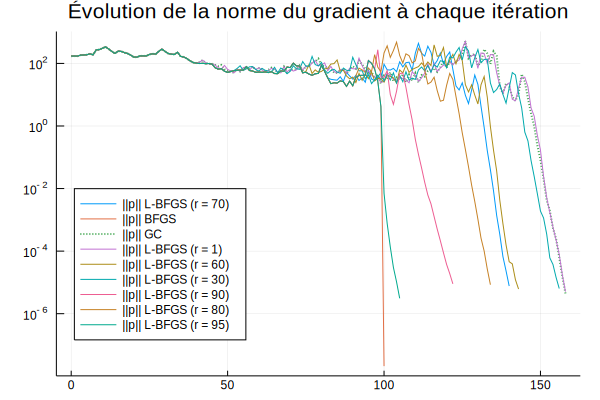

In [53]:
plot(0:(iter+1), G, label = "||p|| L-BFGS (r = 70)", title = "Évolution de la norme du gradient à chaque itération", legend = :bottomleft, yaxis = :log)
plot!(0:(iter₂+1), G₂, label = "||p|| BFGS")
plot!(0:(iterᵧ), Gᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:(iter₁+1), G₁, label = "||p|| L-BFGS (r = 1)")
plot!(0:(iter₃+1), G₃, label = "||p|| L-BFGS (r = 60)")
plot!(0:(iter₄+1), G₄, label = "||p|| L-BFGS (r = 30)")
plot!(0:(iter₅+1), G₅, label = "||p|| L-BFGS (r = 90)")
plot!(0:(iter₆+1), G₆, label = "||p|| L-BFGS (r = 80)")
plot!(0:(iter₇+1), G₇, label = "||p|| L-BFGS (r = 95)")